# 1. Imports and Configurations

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from prophet import Prophet

# Visual configurations for plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

print("Libraries for modeling imported successfully.")

c:\Users\Calhaugamer555\anaconda3\envs\anomalias_macro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries for modeling imported successfully.


# 2. Load the Processed Data

In [2]:
# Load the cleaned and processed DataFrame saved from the previous notebook
processed_path = '../data/processed_quarterly_data.csv'
df_final = pd.read_csv(processed_path, index_col='Date', parse_dates=True)  # Load with 'Date' as datetime index

print("Processed data loaded successfully.")
print(f"DataFrame shape: {df_final.shape}")
print("First 5 rows:")
display(df_final.head())
print("Last 5 rows:")
display(df_final.tail())

Processed data loaded successfully.
DataFrame shape: (70, 4)
First 5 rows:


,GDP_YoY_Growth,Total_Corporate_Credit,Total_Household_Credit,Total_Debt
Date,,,,
2007-12-31,3.0,4877.6,11.6,156083.31
2008-03-31,1.7,5278.5,11.8,158296.02
2008-06-30,0.9,6077.3,13.0,160952.95
2008-09-30,0.5,6898.4,14.1,162444.83
2008-12-31,-1.9,7738.9,14.7,163756.38


Last 5 rows:


,GDP_YoY_Growth,Total_Corporate_Credit,Total_Household_Credit,Total_Debt
Date,,,,
2024-03-31,1.4,4503.1,7.9,154016.14
2024-06-30,1.5,4449.8,8.0,155512.53
2024-09-30,2.0,4483.6,8.1,157050.30
2024-12-31,2.8,4341.9,8.0,159183.62
2025-03-31,1.6,4191.2,7.6,161447.65


# 3. Data Normalization (Scaling)

In [3]:
# Normalization is the first step in preparing the data for modelling.
# We use StandardScaler so each variable has mean 0 and standard deviation 1.

scaler = StandardScaler()  # Initialize the scaler
scaled_data = scaler.fit_transform(df_final)  # Apply the scaler to the DataFrame

# Create a new DataFrame with the normalized values
df_scaled = pd.DataFrame(
    scaled_data,
    index=df_final.index,
    columns=df_final.columns
)  # Preserve the datetime index and column names

print("Data successfully normalized (scaled).")
print("\nStatistical summary of the normalized data (mean ~0, std ~1):")
display(df_scaled.describe().round(2))

Data successfully normalized (scaled).

Statistical summary of the normalized data (mean ~0, std ~1):


,GDP_YoY_Growth,Total_Corporate_Credit,Total_Household_Credit,Total_Debt
count,70.00,70.00,70.00,70.00
mean,0.00,-0.00,0.00,-0.00
std,1.01,1.01,1.01,1.01
min,-4.25,-1.16,-1.53,-1.50
25%,-0.54,-0.97,-0.88,-0.82
50%,0.17,-0.27,-0.14,0.12
75%,0.45,0.99,1.02,0.87
max,3.57,1.66,1.59,1.69


# 5. Isolation Forest Model

In [4]:
# 1. Initialize the Isolation Forest model
# The 'contamination' parameter indicates the expected proportion of anomalies in the dataset.
# A value of 0.1 means we assume roughly 10% of the observations may be anomalous.
# 'random_state' ensures reproducibility.
model = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

# 2. Train the model using the scaled data
model.fit(df_scaled)

# 3. Obtain anomaly predictions
# The model outputs -1 for anomalies and 1 for normal points.
# We add these results back to the original DataFrame (df_final) for easier analysis.
df_final['anomaly_score'] = model.decision_function(df_scaled)  # Anomaly score (lower values indicate more anomalous points)
df_final['anomaly'] = model.predict(df_scaled)

print("Isolation Forest model trained and predictions generated.")

# 4. Inspect results
print("\nFirst rows of the DataFrame with anomaly scores and labels:")
display(df_final.head())

print("\nCount of normal points (1) and anomalies (-1):")
display(df_final['anomaly'].value_counts())


Isolation Forest model trained and predictions generated.

First rows of the DataFrame with anomaly scores and labels:


,GDP_YoY_Growth,Total_Corporate_Credit,Total_Household_Credit,Total_Debt,anomaly_score,anomaly
Date,,,,,,
2007-12-31,3.0,4877.6,11.6,156083.31,0.094344,1
2008-03-31,1.7,5278.5,11.8,158296.02,0.081751,1
2008-06-30,0.9,6077.3,13.0,160952.95,0.070138,1
2008-09-30,0.5,6898.4,14.1,162444.83,0.078806,1
2008-12-31,-1.9,7738.9,14.7,163756.38,0.063504,1



Count of normal points (1) and anomalies (-1):


anomaly
 1    66
-1     4
Name: count, dtype: int64

# 6. Visualization of Detected Anomalies

Total number of anomalies detected: 4

Dates of detected anomalies:


DatetimeIndex(['2012-09-30', '2020-06-30', '2021-06-30', '2022-03-31'], dtype='datetime64[ns]', name='Date', freq=None)

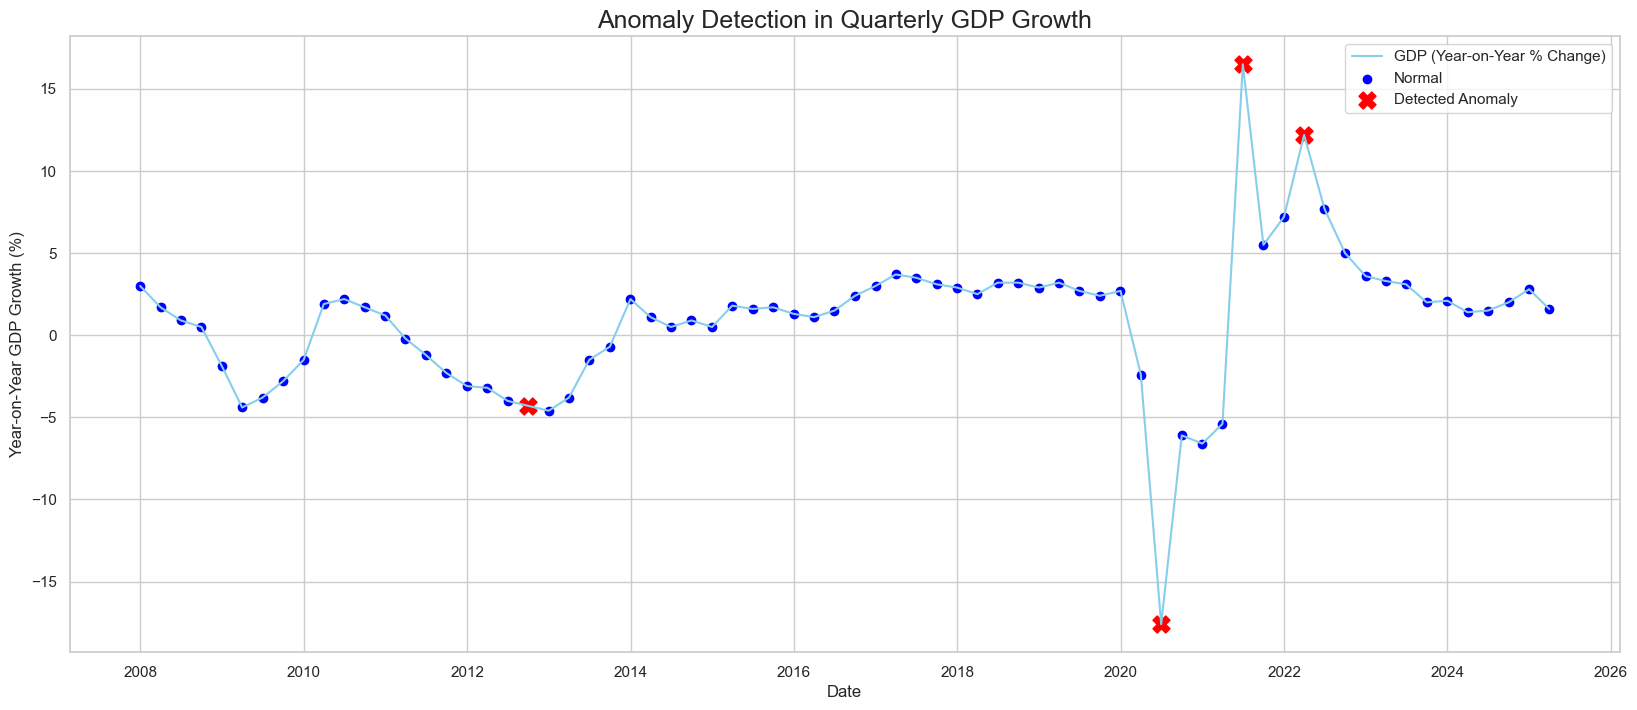

In [5]:
# 1. Split the data into normal and anomalous points so we can plot them with different colors
df_anomalies = df_final[df_final['anomaly'] == -1]
df_normal = df_final[df_final['anomaly'] == 1]

print(f"Total number of anomalies detected: {len(df_anomalies)}")
print("\nDates of detected anomalies:")
display(df_anomalies.index)  # Show the exact dates (quarters) flagged as anomalous

# 2. Create the plot
plt.figure(figsize=(20, 8))

# Plot the full GDP time series
# GDP growth is a central macroeconomic indicator and a natural choice for anomaly visualisation
plt.plot(df_final.index, df_final['GDP_YoY_Growth'], color='skyblue', label='GDP (Year-on-Year % Change)')

# Highlight normal points in blue
plt.scatter(df_normal.index, df_normal['GDP_YoY_Growth'], color='blue', label='Normal')

# Highlight anomalous points with red 'X' markers
plt.scatter(df_anomalies.index, df_anomalies['GDP_YoY_Growth'], color='red', marker='X', s=150, label='Detected Anomaly')

# 3. Improve plot readability with titles and labels
plt.title('Anomaly Detection in Quarterly GDP Growth', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Year-on-Year GDP Growth (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


- The model correctly identifies the major outliers during the COVID-19 shock in 2020–2021, which is expected given the unprecedented collapse and rebound in GDP growth.
- A smaller anomaly appears around 2012–2013, reflecting weaker (than usual) growth during the post-sovereign-debt-crisis period.
- Overall, the detected anomalies align well with real economic events and do not flag normal fluctuations as outliers, suggesting the chosen contamination level is appropriate.


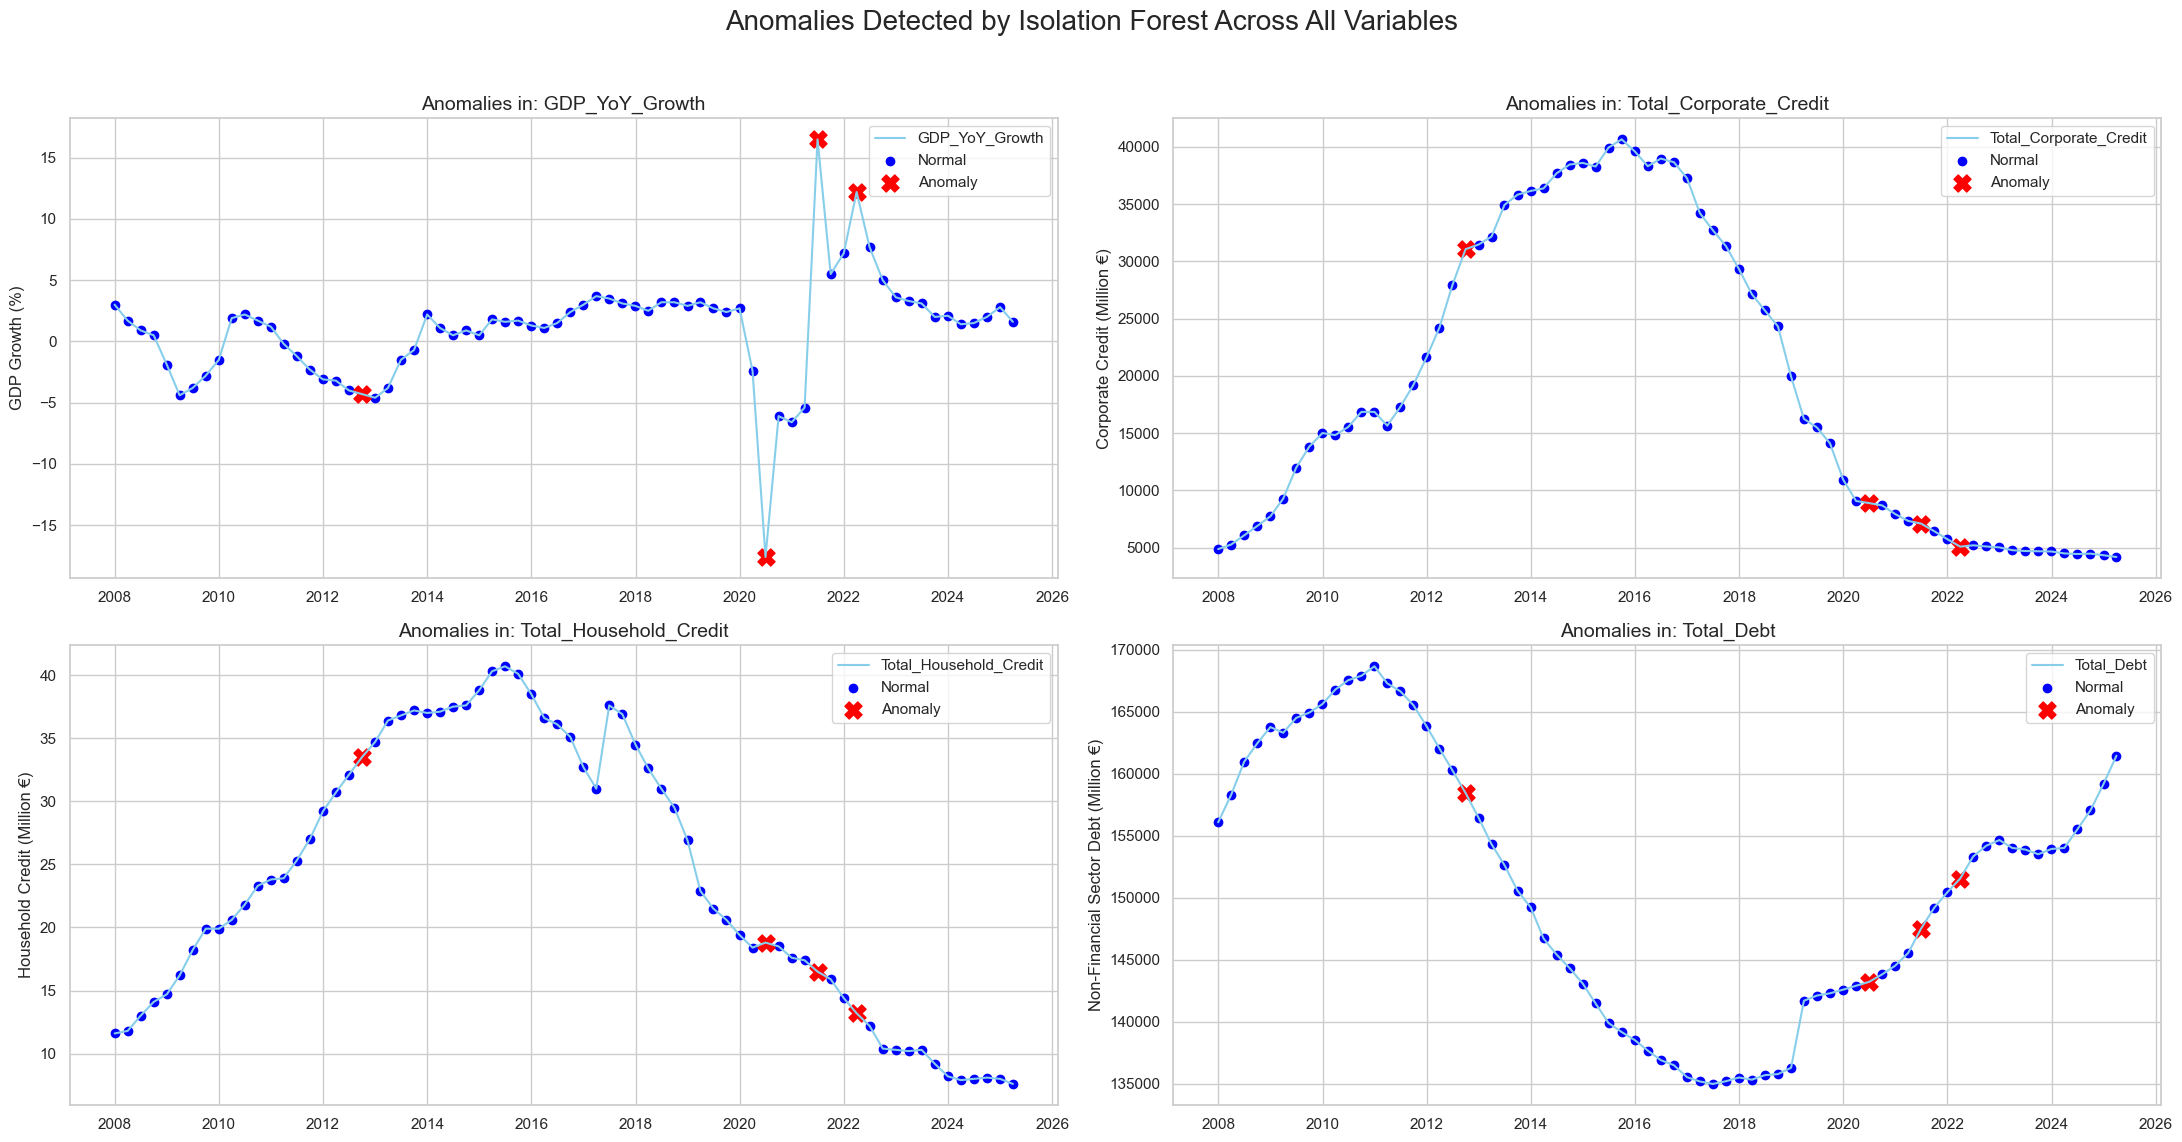

In [6]:
# The DataFrames 'df_anomalies' and 'df_normals' were created in the previous cell,
# so we can reuse them directly.

# Create a figure with 4 subplots (2x2), one for each variable
fig, axes = plt.subplots(2, 2, figsize=(22, 12))
fig.suptitle('Anomalies Detected by Isolation Forest Across All Variables', fontsize=20)

# Dictionary of columns and labels to iterate through
columns = {
    'GDP_YoY_Growth': ('GDP Growth (%)', axes[0, 0]),
    'Total_Corporate_Credit': ('Corporate Credit (Million €)', axes[0, 1]),
    'Total_Household_Credit': ('Household Credit (Million €)', axes[1, 0]),
    'Total_Debt': ('Non-Financial Sector Debt (Million €)', axes[1, 1])
}

# Create each of the 4 plots
for col_name, (label_y, ax) in columns.items():
    # Plot full time series
    ax.plot(df_final.index, df_final[col_name], color='skyblue', label=col_name)
    
    # Highlight normal points
    ax.scatter(df_normal.index, df_normal[col_name], color='blue', label='Normal')
    
    # Highlight anomalous points with a red 'X'
    ax.scatter(df_anomalies.index, df_anomalies[col_name], color='red', marker='X', s=150, label='Anomaly')
    
    # Subplot configuration
    ax.set_title(f'Anomalies in: {col_name}', fontsize=14)
    ax.set_ylabel(label_y, fontsize=12)
    ax.legend()
    ax.grid(True)

# Adjust layout and display
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


- The flagged points line up with well-known economic turning moments, especially the COVID-19 shock in 2020–2021 and the still-fragile period of 2012–2013 after the sovereign-debt crisis.  
- In corporate, household, and total debt, anomalies mainly appear at **sharp trend reversals**, which stand out in series that usually move slowly and steadily.  
- The model doesn’t overreact to normal ups and downs; it highlights only movements that clearly break from the usual pattern.  
- Taken together, the graphs show a consistent picture, with anomalies that make sense in light of actual economic developments.


# 8. Anomaly Detection using STL Decomposition

In [7]:
from statsmodels.tsa.seasonal import STL

print("Starting anomaly detection using STL decomposition...")

# Fixed list of columns to analyse (updated to your field names)
columns_to_analyse = [
    'GDP_YoY_Growth',
    'Total_Corporate_Credit',
    'Total_Household_Credit',
    'Total_Debt'
]

# Create a new column for STL-based anomalies, initialised at 0
df_final['anomaly_stl'] = 0

# 1. Iterate over each of the four variables
for column in columns_to_analyse:
    print(f"\nProcessing series: {column}")

    # 2. Apply STL decomposition (quarterly frequency -> period=4)
    stl = STL(df_final[column], period=4)
    stl_result = stl.fit()
    
    # 3. Compute residuals and the detection threshold
    residuals = stl_result.resid
    threshold = residuals.std() * 3  # Use 3 standard deviations as cutoff
    
    # 4. Identify anomalies in the residuals
    stl_anomalies = residuals[abs(residuals) > threshold]
    
    if not stl_anomalies.empty:
        print(f"Anomalies detected in '{column}' at the following dates:")
        display(stl_anomalies.index.date)
        
        # Tag anomalies in the final DataFrame with 1
        df_final.loc[stl_anomalies.index, 'anomaly_stl'] = 1
    else:
        print(f"No significant anomalies detected in '{column}'.")

# 5. Summary of the final results
print("\n--- Final STL Analysis Summary ---")
print("Count of points marked as anomalies (1) by STL:")
display(df_final['anomaly_stl'].value_counts())


Starting anomaly detection using STL decomposition...

Processing series: GDP_YoY_Growth
Anomalies detected in 'GDP_YoY_Growth' at the following dates:


array([datetime.date(2020, 6, 30), datetime.date(2021, 6, 30)],
      dtype=object)


Processing series: Total_Corporate_Credit
No significant anomalies detected in 'Total_Corporate_Credit'.

Processing series: Total_Household_Credit
Anomalies detected in 'Total_Household_Credit' at the following dates:


array([datetime.date(2017, 3, 31), datetime.date(2017, 6, 30)],
      dtype=object)


Processing series: Total_Debt
Anomalies detected in 'Total_Debt' at the following dates:


array([datetime.date(2018, 12, 31), datetime.date(2019, 3, 31)],
      dtype=object)


--- Final STL Analysis Summary ---
Count of points marked as anomalies (1) by STL:


anomaly_stl
0    64
1     6
Name: count, dtype: int64

# 9. Model Comparison

In [8]:
# Comparison of Detected Anomalies

# Convert the Isolation Forest 'anomaly' column to the same format (0 and 1)
# It is currently 1 (normal) and -1 (anomaly). We map -1 to 1 and 1 to 0.
df_final['anomaly_if'] = df_final['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Select only the quarters where at least one model detected an anomaly
df_comparison = df_final[(df_final['anomaly_if'] == 1) | (df_final['anomaly_stl'] == 1)]

print("--- Comparison of Anomalies (Isolation Forest vs. STL) ---")
print("The table below shows only the dates where at least one model detected an anomaly:")
print("'anomaly_if' = Isolation Forest anomaly | 'anomaly_stl' = STL anomaly")

# Display the relevant columns
display(df_comparison[['anomaly_if', 'anomaly_stl']])

# Compute model agreement
agreement = df_final[df_final['anomaly_if'] == df_final['anomaly_stl']]
print(f"\nThe models agree on {len(agreement)} out of {len(df_final)} points "
      f"({len(agreement)/len(df_final):.1%}).")

both_anomaly = df_final[(df_final['anomaly_if'] == 1) & (df_final['anomaly_stl'] == 1)]
print("Dates where BOTH models detected an anomaly:")
display(both_anomaly.index.date)


--- Comparison of Anomalies (Isolation Forest vs. STL) ---
The table below shows only the dates where at least one model detected an anomaly:
'anomaly_if' = Isolation Forest anomaly | 'anomaly_stl' = STL anomaly


,anomaly_if,anomaly_stl
Date,,
2012-09-30,1,0
2017-03-31,0,1
2017-06-30,0,1
2018-12-31,0,1
2019-03-31,0,1
2020-06-30,1,1
2021-06-30,1,1
2022-03-31,1,0



The models agree on 64 out of 70 points (91.4%).
Dates where BOTH models detected an anomaly:


array([datetime.date(2020, 6, 30), datetime.date(2021, 6, 30)],
      dtype=object)

### Why the models do not fully match
Isolation Forest and STL are designed to detect different types of anomalies, so a perfect match is not expected.  
- **STL** identifies local deviations within each individual time series.  
- **Isolation Forest** detects global, multivariate outliers based on the joint behaviour of all variables.  
Because they focus on different signals, some disagreement is normal and actually indicates that the methods are complementary rather than redundant.

### Interpretation of the results
The two models agree on **91.4%** of observations, showing broadly consistent behaviour.  
STL flags anomalies mainly around **2017–2019**, where certain series deviate from their trend. Isolation Forest marks **2012-09-30** and **2022-03-31**, reflecting unusual multivariate patterns.  
Both models agree on key dates in **2020 and 2021**, corresponding to clear macroeconomic disruptions. These shared anomalies are the strongest candidates for genuine structural shocks.


# 10. Anomaly detection with Prophet on the GDP series

Starting anomaly detection with Prophet on the GDP series...


20:18:24 - cmdstanpy - INFO - Chain [1] start processing
20:18:25 - cmdstanpy - INFO - Chain [1] done processing



Prophet identified 4 anomalies in the GDP series.
Dates of anomalies detected by Prophet:


array([datetime.date(2020, 6, 30), datetime.date(2020, 12, 31),
       datetime.date(2021, 6, 30), datetime.date(2022, 3, 31)],
      dtype=object)

c:\Users\Calhaugamer555\anaconda3\envs\anomalias_macro\lib\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Calhaugamer555\anaconda3\envs\anomalias_macro\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


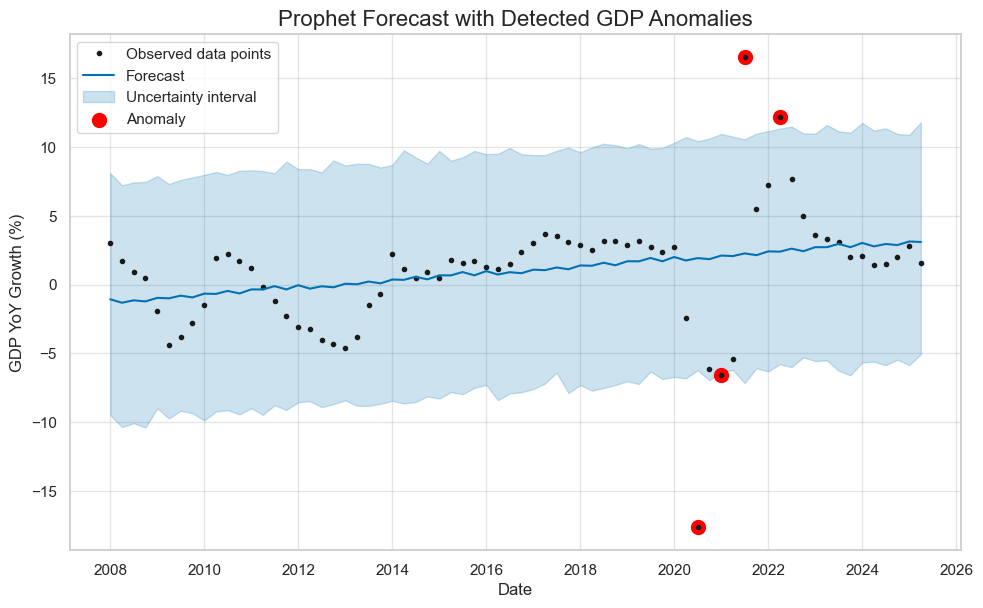

In [9]:
print("Starting anomaly detection with Prophet on the GDP series...")

# 1. Prepare the DataFrame for Prophet
df_prophet_gdp = df_final[['GDP_YoY_Growth']].reset_index()
df_prophet_gdp.rename(columns={'Date': 'ds', 'GDP_YoY_Growth': 'y'}, inplace=True)

# 2. Initialise the Prophet model
model_prophet = Prophet(
    interval_width=0.95,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

try:
    # 3. Fit the model using the 'LBFGS' optimisation algorithm
    model_prophet.fit(df_prophet_gdp, algorithm='LBFGS')

    # 4. Generate predictions for the historical period
    forecast = model_prophet.predict(df_prophet_gdp[['ds']])

    # 5. Merge Prophet predictions back into our final DataFrame
    df_final_prophet = pd.concat(
        [df_final, forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']]],
        axis=1
    )

    # 6. Flag anomalies where the observed GDP falls outside the prediction interval
    df_final_prophet['anomaly_prophet'] = (
        (df_final_prophet['GDP_YoY_Growth'] < df_final_prophet['yhat_lower']) |
        (df_final_prophet['GDP_YoY_Growth'] > df_final_prophet['yhat_upper'])
    )

    # 7. Summarise and display anomalies
    prophet_anomalies = df_final_prophet[df_final_prophet['anomaly_prophet']]

    print(f"\nProphet identified {len(prophet_anomalies)} anomalies in the GDP series.")
    print("Dates of anomalies detected by Prophet:")
    display(prophet_anomalies.index.date)

    # 8. Visualise the forecast with anomalies highlighted
    fig = model_prophet.plot(forecast)
    plt.scatter(
        prophet_anomalies.index,
        prophet_anomalies['GDP_YoY_Growth'],
        color='red',
        s=100,
        label='Anomaly'
    )
    plt.title("Prophet Forecast with Detected GDP Anomalies", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("GDP YoY Growth (%)", fontsize=12)
    plt.legend()
    plt.show()

except Exception as e:
    print(f"\nAn error occurred: {e}")
    print("If the error persists, it may be related to the Prophet/CmdStanPy installation.")


Prophet flags only a small number of GDP anomalies, which is expected given its strong tendency to smooth the underlying trend and widen uncertainty intervals. The points detected correspond to periods where GDP growth moves decisively outside the model’s 95% prediction band.

The largest anomaly is the sharp collapse in 2020, which sits far below the lower bound and reflects the unprecedented COVID-19 shock. The positive spikes flagged in 2021 and 2022 capture the unusually strong rebound that also exceeds what Prophet considers a plausible continuation of the historical trend.

Overall, Prophet behaves conservatively, marking anomalies only when the observed values break clearly away from the trend-driven forecast. This makes the detected points highly credible as true structural deviations rather than normal fluctuations.


# 11. Final Recap: Summary of Results and Rationale for Model Choices

### 1. Isolation Forest - Multivariate perspective
Isolation Forest was used to detect anomalies considering all variables jointly. This method identifies observations that do not fit the overall multivariate structure of the dataset.  
It flagged points mainly around periods of clear macroeconomic disruption, particularly in 2020–2021.

Reason for use: captures system-wide irregularities that are not visible when analysing each series separately.

---

### 2. STL Decomposition - Univariate, trend-based perspective
STL was applied to each time series individually to detect deviations from its own trend and seasonal pattern.  
It identified several local irregularities, especially in credit and debt series, where changes in slope or turning points stand out relative to historical behaviour.

Reason for use: provides a transparent method focused on within-series behaviour.

---

### 3. Prophet – Forecast-based perspective
Prophet was used to assess whether observed values fall outside a model-based prediction interval.  
It identified fewer anomalies, centred mostly on the GDP collapse in 2020 and the rebound in 2021, which fall well outside the model’s expected range.

Reason for use: offers a forecast-driven benchmark for identifying structural breaks.

---

### Overall conclusion
The three methods give different but complementary views of the data. Isolation Forest focuses on joint dynamics across variables, STL highlights deviations within each individual series, and Prophet identifies points that are unexpected relative to a modelled trend.  
The strongest agreement across methods occurs during the COVID-19 period, which is consistent with the scale of the disruption. Differences in detection reflect the distinct assumptions and sensitivities of each approach, and together they provide a more complete picture of unusual movements in the data.


<div style="text-align: center; margin-top: 20px;">
    <a href="03_comparative_analysis.ipynb" target="_self">
        <button style="
            background-color:#DAA520;
            border:none;
            color:white;
            padding:14px 28px;
            font-size:16px;
            border-radius:8px;
            cursor:pointer;">
            Open Next Notebook: 03_comparative_analysis.ipynb ->
        </button>
    </a>
</div>
